<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../data/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def get_user_id(filename):
    extension = '.csv'
    len_number = 4
    end = filename.find(extension)
    start = end - len_number
    
    return int(filename[start:end])

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with(open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
    
    list_sessions = []
    
    for filename in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        times = pd.read_csv(filename, parse_dates=['timestamp']).timestamp
        sites = pd.read_csv(filename).site.values
        
        count_sessions = len(sites) // window_size if len(sites) % window_size == 0 else len(sites) // window_size + 1
        
        for sindex in range(count_sessions):
            have_zero = 0
            count_sites = 0
            sessions = []
            for index in range(sindex * window_size, sindex * window_size + session_length):
                if index < len(sites):
                    sessions.append(site_freq[sites[index]][0])
                    count_sites += 1
                else:
                    have_zero = 1
                    sessions.append(0)
                    
                    
            unique_sites = len(set(sessions)) - have_zero
            session_timespan = (times[sindex * window_size + (count_sites - 1)] - times[sindex * window_size]).seconds
            sessions.append(session_timespan)
            sessions.append(unique_sites)
            start_hour = times[sindex * window_size].hour
            sessions.append(start_hour)
            day_of_week = times[sindex * window_size].dayofweek
            sessions.append(day_of_week)
            sessions.append(get_user_id(filename))
            list_sessions.append(sessions)
    
    return pd.DataFrame(list_sessions, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names)

100%|██████████| 3/3 [00:00<00:00, 190.97it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,3,2,0,0,0,0,0,7935,3,9,4,2
1,4,5,2,5,2,5,5,6,7,4,7998,5,9,4,3
2,4,5,2,0,0,0,0,0,0,0,1471,3,12,4,3
3,1,2,2,8,2,5,9,6,10,11,7998,8,9,4,1
4,1,5,5,5,0,0,0,0,0,0,60,2,12,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 10/10 [00:01<00:00,  7.30it/s]

CPU times: user 1.46 s, sys: 98.3 ms, total: 1.55 s
Wall time: 1.5 s


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 150/150 [00:13<00:00, 11.48it/s]


CPU times: user 13.3 s, sys: 1.02 s, total: 14.4 s
Wall time: 13.6 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [8]:
new_features_10users = train_data_10users[train_data_10users.columns[10:14]]
new_features_150users = train_data_150users[train_data_150users.columns[10:14]]

In [9]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [10]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [11]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [12]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [13]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [15]:
color_dict = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

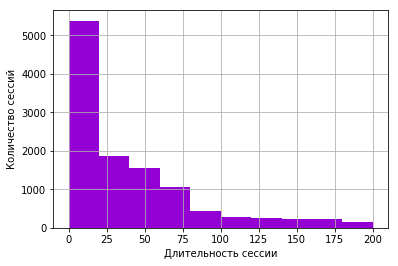

In [16]:
hist = train_data_10users['session_timespan'].hist(range=(0, 200), color = 'darkviolet')
hist.set_xlabel(u'Длительность сессии')
hist.set_ylabel(u'Количество сессий')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

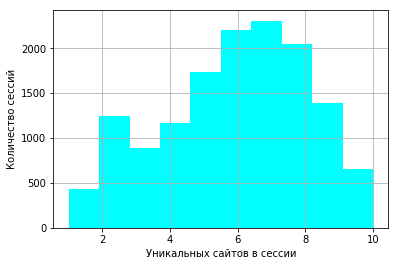

In [17]:
hist = train_data_10users['#unique_sites'].hist(color = 'aqua')
hist.set_xlabel(u'Уникальных сайтов в сессии')
hist.set_ylabel(u'Количество сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

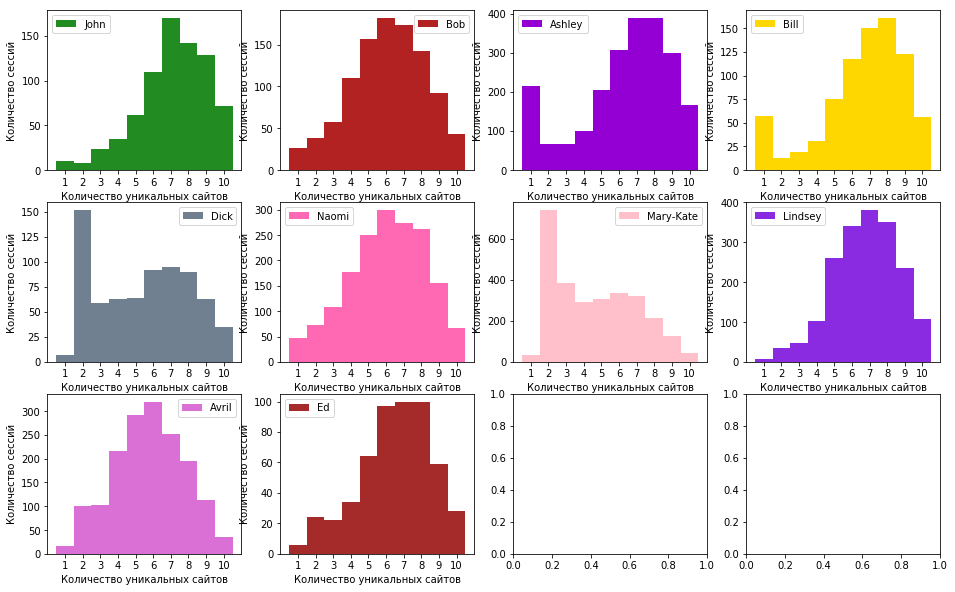

In [18]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    hist = axes.ravel()[idx]
    hist.set_xlabel(u'Количество уникальных сайтов')
    hist.set_ylabel(u'Количество сессий')
    hist.set_xticks(range(1,11))
    hist.hist(sub_df['#unique_sites'], bins = 10, range = (0.5, 10.5), align= u'mid', label = id_name_dict[user], color = color_dict[id_name_dict[user]])
    hist.legend()
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

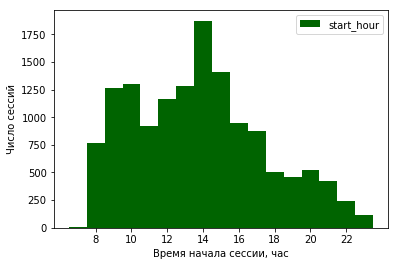

In [19]:
bins = len(pd.unique(train_data_10users['start_hour']))
xmin = min(pd.unique(train_data_10users['start_hour']))

fig, hist = plt.subplots()
hist.set_xlabel(u'Время начала сессии, час')
hist.set_ylabel(u'Число сессий')
hist.set_xticks(range(xmin + 1, 24, 2))
hist.hist(train_data_10users['start_hour'], bins = bins, range = (xmin - 0.5, xmin + bins - 0.5), align = u'mid', color = 'darkgreen')
hist.legend()
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

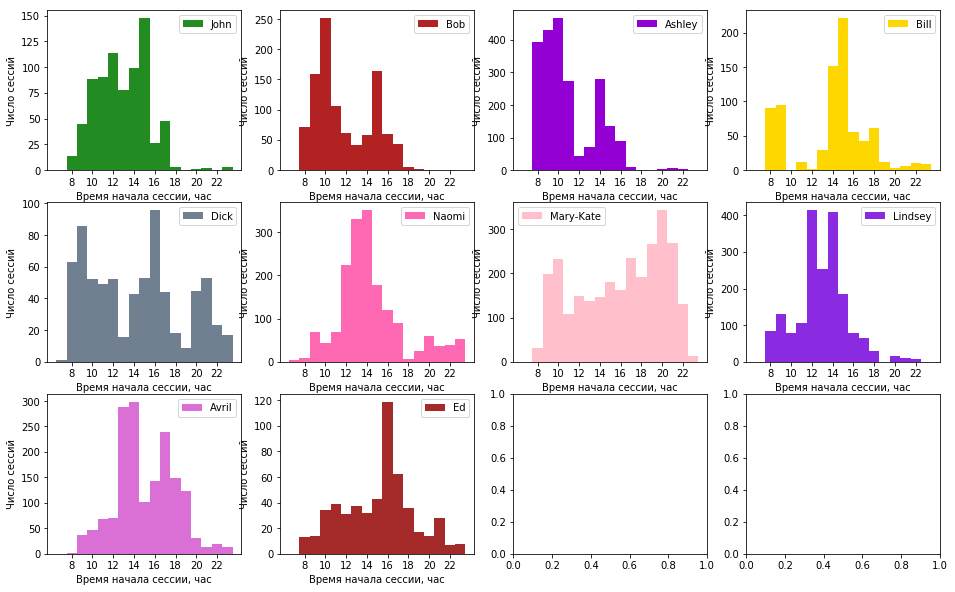

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    hist = axes.ravel()[idx]
    hist.set_xlabel(u'Время начала сессии, час')
    hist.set_ylabel(u'Число сессий')
    hist.set_xticks(range(xmin + 1, 24, 2))
    hist.hist(sub_df['start_hour'], bins = bins, range = (xmin-0.5, xmin + bins - 0.5), align = u'mid', label = id_name_dict[user], color = color_dict[id_name_dict[user]])
    hist.legend()
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

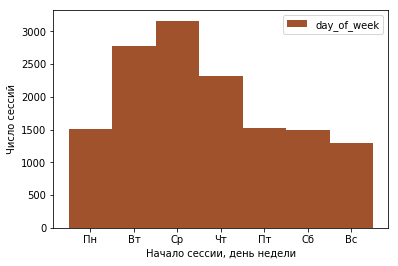

In [21]:
fig, hist = plt.subplots()
hist.set_xlabel(u'Начало сессии, дeнь недели')
hist.set_ylabel(u'Число сессий')
hist.set_xticks(range(7))
hist.set_xticklabels( [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
hist.hist(train_data_10users['day_of_week'], bins = 7, range = (-0.5, 6.5), align = u'mid', color = 'sienna')
hist.legend()
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

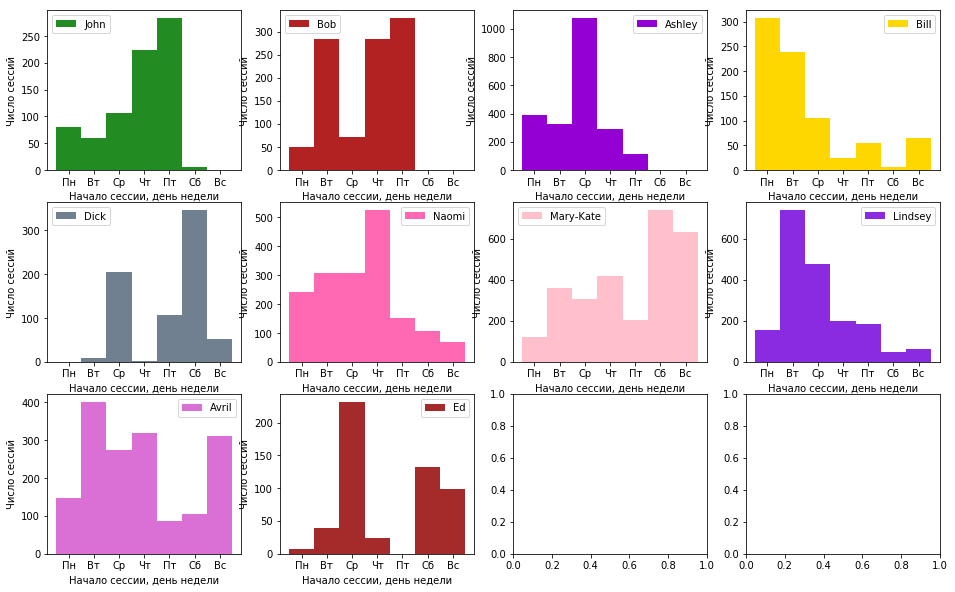

In [22]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    hist = axes.ravel()[idx]
    hist.set_xlabel(u'Начало сессии, дeнь недели')
    hist.set_ylabel(u'Число сессий')
    hist.set_xticks(range(7))
    hist.set_xticklabels( [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    hist.hist(sub_df['day_of_week'], bins = 7, range = (-0.5,6.5), align = u'mid', label = id_name_dict[user] , color = color_dict[id_name_dict[user]])
    hist.legend()
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По количеству уникальных сайтов выделяются только несколько пользователей, имея большое количество сессий с двумя уникальными сайтами. Практически у всех пользователей довольно разное распределение времени начала сессий. Кто-то активен только в рабочее время, кто-то равномерно целый день с перерывами и т.д. По распределения сессий по дням недели, можно выделить основные три группы пользователей, активные в рабочие дни, во все дни недели, более активные в выходные.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [23]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),'rb') as f:
              site_freq_10users=pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [24]:
popular_list = sorted(site_freq_10users.items(), key = lambda (key,(s_id,fr)):fr, reverse=True)[:10]
top10_freqs =[fr for (site,(site_id, fr)) in popular_list]
top10_sites =[site for (site,(site_id, fr)) in popular_list]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

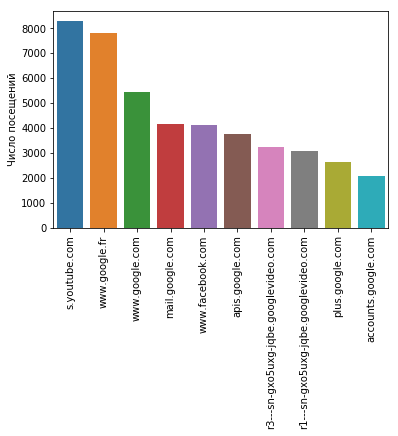

In [25]:
hist = sns.barplot(x = top10_sites, y = top10_freqs)
hist.set_ylabel(u'Число посещений')
hist.set_xticklabels(top10_sites, rotation='vertical')
plt.show()

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)